In [1]:
# Setting up dependencies
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class RecommenderSystem():
    def __init__(
            self,
            train_path: str,
            val_path: str,
            alpha: float,
            num_dimensions: int,
            num_epochs: int,
    ):
        self.train_path = train_path
        self.val_path = val_path
        self.ratings_train = []
        self.ratings_validation = []
        self.P = []
        self.Q = []
        self.prediction_matrix = []
        self.num_users = 0
        self.num_items = 0
        self.global_avg = 0
        self.alpha = alpha
        self.num_dimensions = num_dimensions
        self.num_epochs = num_epochs
        self.history = {"Epoch": [], "Loss": []}

    def __build_array(self, file_path: str) -> np.ndarray:
        """Create ndarray from raw csv input file

        Args:
                file_path (str): path to csv

        Returns:
                ndarray
        """
        with open(file_path) as f:
            f.readline()

            raw_data = []
            for line in f:
                raw_data.append([int(d) for d in line.split(",")])

        array = np.asarray(raw_data)

        return array

    def __load_data(self):
        """Load data and metadata from input files"""
        self.ratings_train = self.__build_array(self.train_path)
        self.ratings_validation = self.__build_array(self.val_path)
        self.num_users, self.num_items, _ = self.ratings_train.max(axis=0)
        self.num_users += 1
        self.num_items += 1
        _, _, self.global_avg = self.ratings_train.mean(axis=0)

    def __plot(self):
        plt.plot(self.history["Epoch"], self.history["Loss"])
        plt.title("Loss Minimization on Training Data")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    def __compute_loss(self, ratings) -> np.float32:
        """Calculates the mean squared error for the rating set

        Args:
                ratings (ndarray): 2d array of [user, item, ratings]

        Returns:
            np.float32: mean squared error
        """
        loss = 0
        N = ratings.shape[0]

        for user, item, rating in ratings:
            error = rating - self.P[user] @ self.Q[item]
            loss += error ** 2

        loss = loss / N
        return loss

    def __matrix_factorization(self):
        """Perform matrix factorization using alternating minimization"""
        self.P = np.ones((self.num_users, self.num_dimensions), dtype=np.float32)
        self.Q = np.ones((self.num_items, self.num_dimensions), dtype=np.float32)

        for epoch in range(self.num_epochs):
            for row in self.ratings_train:
                user, item, rating = row
                error = rating - self.P[user] @ self.Q[item]

                for dim in range(self.num_dimensions):
                    self.P[user][dim] += self.alpha * error * self.Q[item][dim]
                    self.Q[item][dim] += self.alpha * error * self.P[user][dim]

            loss = self.__compute_loss(self.ratings_train)
            self.history["Epoch"].append(epoch)
            self.history["Loss"].append(loss)

            if epoch % (self.num_epochs / 10) == (self.num_epochs / 10 - 1):
                print(
                    "Training loss at epoch {} of {}: {}".format(
                        epoch + 1, self.num_epochs, loss
                    )
                )

    def run(self):
        self.__load_data()
        self.__matrix_factorization()
        training_loss = self.__compute_loss(self.ratings_train)
        validation_loss = self.__compute_loss(self.ratings_validation)

        print("----------------------------")
        print("Training Loss: {}".format(training_loss))
        print("Validation Loss: {}".format(validation_loss))

        self.__plot()

Training loss at epoch 20 of 200: 2.129335103587066
Training loss at epoch 40 of 200: 1.5330852112118032
Training loss at epoch 60 of 200: 1.2475187029041253
Training loss at epoch 80 of 200: 1.0841237086784088
Training loss at epoch 100 of 200: 0.9778171179158894
Training loss at epoch 120 of 200: 0.902631829816205
Training loss at epoch 140 of 200: 0.8464300206403499
Training loss at epoch 160 of 200: 0.8027522224460841
Training loss at epoch 180 of 200: 0.7678084536798395
Training loss at epoch 200 of 200: 0.7392116112149089
----------------------------
Training Loss: 0.7392116112149089
Validation Loss: 0.8538650312429087


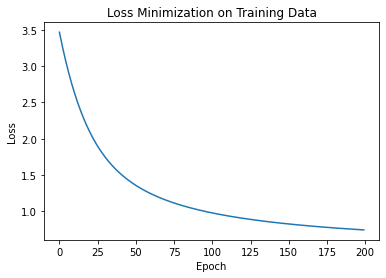

In [3]:
if __name__ == "__main__":
    recSys = RecommenderSystem(
        "data/ratings_train.csv", "data/ratings_val.csv", 0.0001, 2, 200
    )
    recSys.run()